In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import sys
sys.path.append('../../')

In [11]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import bct
from collections import defaultdict
%matplotlib inline

In [3]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')
feature_names_volumetric=european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]

#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

covariates=np.asarray(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Gender']])


high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)

X_low_risk=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"]),
np.asarray(european_diffusion_dataset_term.loc[low_risk,'17 ICV (all except bone)']),
np.asarray(european_diffusion_dataset_term.loc[low_risk,'GA_struc']),
np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_struc']),
np.asarray(european_diffusion_dataset_term.loc[low_risk,'Gender']))


X_high_risk=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[high_risk,"'1 Precentral_L 2001'":"'93 Vermis'"]),
np.asarray(european_diffusion_dataset_term.loc[high_risk,'17 ICV (all except bone)']),
np.asarray(european_diffusion_dataset_term.loc[high_risk,'GA_struc']),
np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_struc']),
np.asarray(european_diffusion_dataset_term.loc[high_risk,'Gender']))

y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_struc'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_struc'])

In [4]:
high_risk_corr_matrix=np.corrcoef(X_high_risk,rowvar=False)
low_risk_corr_matrix=np.corrcoef(X_low_risk,rowvar=False)
high_risk_corr_matrix=data_preprocessing.lower_triangle(high_risk_corr_matrix)
low_risk_corr_matrix=data_preprocessing.lower_triangle(low_risk_corr_matrix)

In [5]:
from sklearn.preprocessing import StandardScaler
high_risk_corr_matrix=StandardScaler().fit_transform(high_risk_corr_matrix.reshape(-1,1))
low_risk_corr_matrix=StandardScaler().fit_transform(low_risk_corr_matrix.reshape(-1,1))
high_risk_corr_matrix=data_preprocessing.reverse_lower_triangle(high_risk_corr_matrix,93)
low_risk_corr_matrix=data_preprocessing.reverse_lower_triangle(low_risk_corr_matrix,93)

repeating similar work done by Shi et al., 2012, use bctpy library to check for metrics networks

In [6]:
bct.density_und(high_risk_corr_matrix)

(1.0, 93, 4278)

In [112]:
def calculate_measures_bin(G):
    """
    Input:
        G (array): undirected, binarized array
    Returns:
        Eglobal, Elocal, clustering, shortest path average, small worldness
    """
    _,nodes,edges=bct.density_und(G)
    average_path,Eglob,_,_,_=bct.charpath(bct.distance_bin(G))
    clustering=bct.clustering_coef_bu(G)
    average_Elocal=np.mean(bct.efficiency_bin(G,1))

    synthetic_und_random_network=bct.makerandCIJ_und(nodes,edges)
    synthetic_und_random_network=np.maximum(synthetic_und_random_network,synthetic_und_random_network.T) # make it a symmetrical matrix
    if not np.allclose(synthetic_und_random_network,synthetic_und_random_network.T):
        raise bct.BCTParamError('Not Undirected')

    random_average_path,_,_,_,_=bct.charpath(synthetic_und_random_network)
    random_clustering=bct.clustering_coef_bu(synthetic_und_random_network)
    normalized_average_path=average_path/random_average_path

    normalized_clustering=np.mean(abs(clustering))/np.mean(abs(random_clustering))

    small_worldness=normalized_clustering/normalized_average_path

    return Eglob,average_Elocal,normalized_clustering,normalized_average_path,small_worldness

In [116]:
dict_result_high_risk=defaultdict(list)
dict_result_low_risk=defaultdict(list)
for sparsity in range(10,26):
    temp_corr_matrix_high_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(high_risk_corr_matrix,sparsity/100)

    temp_corr_matrix_low_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(low_risk_corr_matrix,sparsity/100)

    dict_result_high_risk[sparsity].extend(calculate_measures_bin(temp_corr_matrix_high_risk))#global efficiency
    dict_result_low_risk[sparsity].extend(calculate_measures_bin(temp_corr_matrix_low_risk))#global efficiency

/Users/hai/src/bctpy/bct/algorithms/distance.py:157: RuntimeWarning: divide by zero encountered in true_divide
  efficiency = np.mean(1 / Dv)


In [120]:
test1=pd.DataFrame(dict_result_high_risk).T
test2=pd.DataFrame(dict_result_low_risk).T

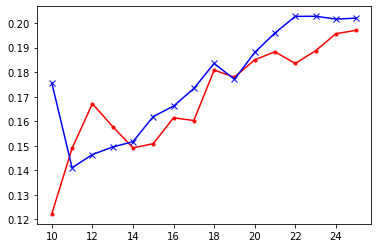

In [127]:
plt.plot(test1[4],'r.-')
plt.plot(test2[4],'bx-')

In [143]:
%timeit bct.randomizer_bin_und(temp_corr_matrix_high_risk,1)

596 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
%timeit graph_analysis.generate_random_matrix(temp_corr_matrix_high_risk)

231 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
